# Enhance quality of PNG images with auto-encoder



Task here is to build auto-encoder to super impose images to their enhanced quality.

Here I am mounting the drive. This means I have uploaded dataset with images to Google Drive and then connected this Google Colab with my drive. It's must be if I want to use dataset from Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Import libraries and utilities

In [7]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from keras import layers

Load dataset

In [8]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

SIZE = 96
high_img = []
path = '/content/drive/MyDrive/low-res-to-high-res/dataset/HR'
files = os.listdir(path)
files = sorted_alphanumeric(files)

for i in tqdm(files):    
    img = cv2.imread(path + '/'+i,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    high_img.append(tf.keras.preprocessing.image.img_to_array(img))


low_img = []
path = '/content/drive/MyDrive/low-res-to-high-res/dataset/LR'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    img = cv2.imread(path + '/'+i,1)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    low_img.append(tf.keras.preprocessing.image.img_to_array(img))

100%|██████████| 100/100 [00:01<00:00, 98.44it/s]


In [9]:
train_high_image = high_img[:60]
train_low_image = low_img[:60]
train_high_image = np.reshape(train_high_image,(len(train_high_image), SIZE, SIZE,  3))
train_low_image = np.reshape(train_low_image,(len(train_low_image), SIZE, SIZE,  3))

validation_high_image = high_img[60:83]
validation_low_image = low_img[60:83]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image), SIZE, SIZE, 3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image), SIZE, SIZE, 3))

test_high_image = high_img[83:]
test_low_image = low_img[83:]
test_high_image= np.reshape(test_high_image,(len(test_high_image), SIZE, SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image), SIZE, SIZE, 3))

In [10]:
def encoder_without_batch_normalization():

    inputs2 = layers.Input(shape= [SIZE,SIZE,3])

    l1 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation=keras.layers.LeakyReLU(), strides=2)(inputs2)
    l2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation=keras.layers.LeakyReLU(), strides=2)(l1)
    l3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation=keras.layers.LeakyReLU(), strides=2)(l2)
    l4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform', activation=keras.layers.LeakyReLU(), strides=2)(l3)
    l5 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform', activation=keras.layers.LeakyReLU(), strides=2)(l4)

    l6 = tf.keras.layers.Conv2DTranspose(512, 3, 
                                     padding='same', 
                                     activation=keras.layers.LeakyReLU(), strides=2)(l5)

    l6 = tf.keras.layers.concatenate([l6, l4])

    l7 = tf.keras.layers.Conv2DTranspose(512, 3, 
                                     padding='same', 
                                     activation=keras.layers.LeakyReLU(), strides=2)(l6)

    l7 = tf.keras.layers.concatenate([l7, l3])

    l8 = tf.keras.layers.Conv2DTranspose(128, 3, 
                                     padding='same', 
                                     activation=keras.layers.LeakyReLU(), strides=2)(l7)
    
    l8 = tf.keras.layers.concatenate([l8, l2])

    l8 = tf.keras.layers.Conv2DTranspose(128, 3, 
                                     padding='same', 
                                     activation=keras.layers.LeakyReLU(), strides=2)(l8)

    l8 = tf.keras.layers.concatenate([l8, l1])

    l9 = tf.keras.layers.Conv2DTranspose(3, 3, 
                                     padding='same', 
                                     activation=keras.layers.LeakyReLU(), strides=2)(l8)

    l9 = tf.keras.layers.concatenate([l9, inputs2])

    output = layers.Conv2D(3, (2,2),strides = 1, padding = 'same')(l9)
    return tf.keras.Model(inputs=inputs2, outputs=output)

encoder_without_batch_normalization = encoder_without_batch_normalization()

In [11]:
encoder_without_batch_normalization.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                    loss = 'mean_absolute_error', 
                    metrics = ['acc'])

Model is ready, now we have to compile it. We're going through 15 epochs, number of images in batch is 5.

In [12]:
history_without_batch_norm = encoder_without_batch_normalization.fit(train_low_image, train_high_image, epochs = 15, batch_size = 5,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/15
12/12 [==============================] - 11s 817ms/step - loss: 0.2849 - acc: 0.4445 - val_loss: 0.2268 - val_acc: 0.5731
Epoch 2/15
12/12 [==============================] - 9s 798ms/step - loss: 0.1868 - acc: 0.5944 - val_loss: 0.1465 - val_acc: 0.5865
Epoch 3/15
12/12 [==============================] - 10s 863ms/step - loss: 0.1173 - acc: 0.5347 - val_loss: 0.1055 - val_acc: 0.4928
Epoch 4/15
12/12 [==============================] - 9s 784ms/step - loss: 0.0990 - acc: 0.5781 - val_loss: 0.0908 - val_acc: 0.6454
Epoch 5/15
12/12 [==============================] - 9s 778ms/step - loss: 0.0884 - acc: 0.6358 - val_loss: 0.0822 - val_acc: 0.6173
Epoch 6/15
12/12 [==============================] - 9s 786ms/step - loss: 0.0814 - acc: 0.6425 - val_loss: 0.0774 - val_acc: 0.6460
Epoch 7/15
12/12 [==============================] - 9s 779ms/step - loss: 0.0766 - acc: 0.6567 - val_loss: 0.0733 - val_acc: 0.6514
Epoch 8/15
12/12 [==============================] - 9s 783ms/step - loss: 

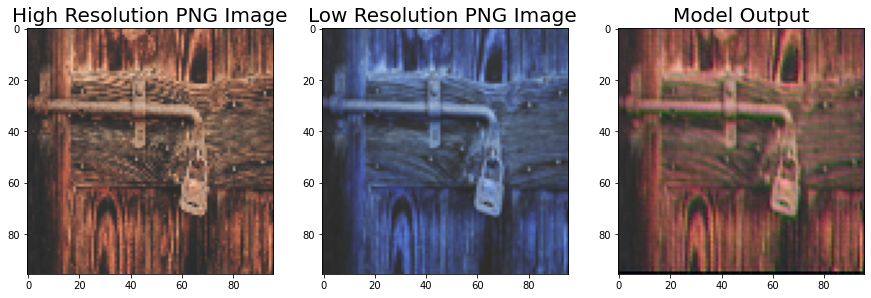

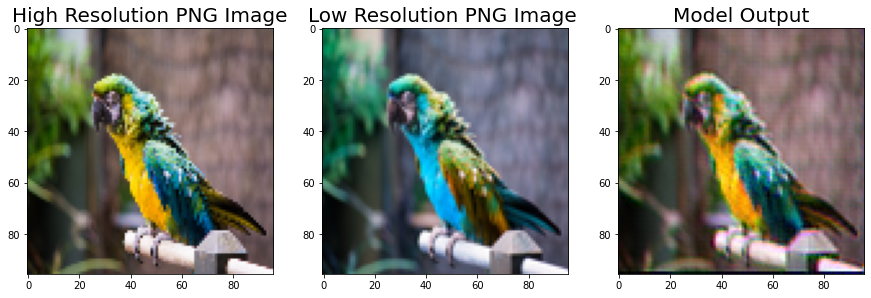

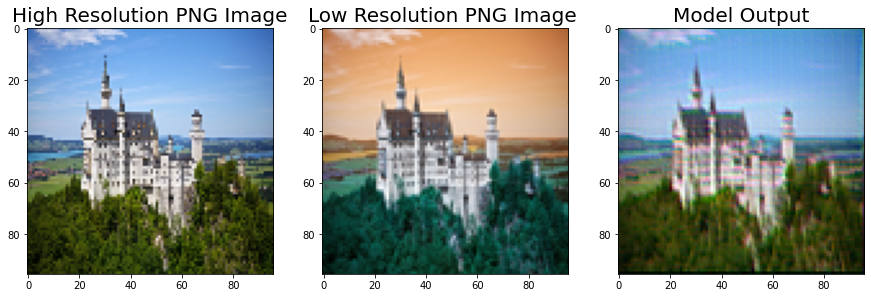

In [13]:
"""
function gets images and displays them side by side for comparison
"""
def show_model_output(hq_image, lq_image, encoder_output):

    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Resolution PNG Image', color = 'black', fontsize = 20)
    plt.imshow(hq_image)
    plt.subplot(1,3,2)
    plt.title('Low Resolution PNG Image ', color = 'black', fontsize = 20)
    plt.imshow(lq_image)
    plt.subplot(1,3,3)
    plt.title('Model Output', color = 'black', fontsize = 20)
    plt.imshow(encoder_output)
    plt.show()


for photo_triple in range(1, 4):
    encoder_output = np.clip(encoder_without_batch_normalization.predict(test_low_image[photo_triple].reshape(1, SIZE, SIZE, 3)), 0.0, 1.0).reshape(SIZE, SIZE,3)
    show_model_output(test_high_image[photo_triple],test_low_image[photo_triple], encoder_output)

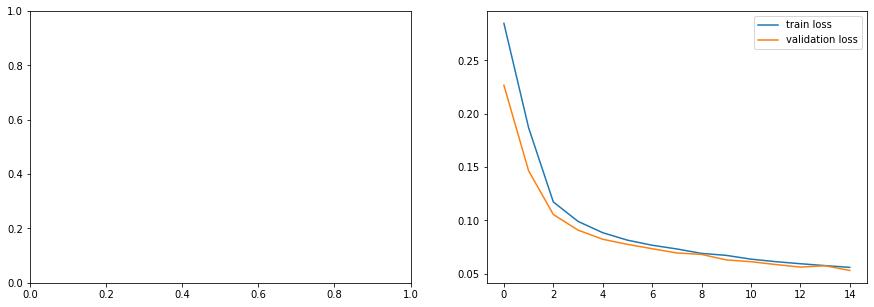

In [14]:
def show_training_loss_in_graph(model_training_history):
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    ax[1].plot(model_training_history.history['loss'], label='train loss')
    ax[1].plot(model_training_history.history['val_loss'], label='validation loss')
    ax[1].legend()

show_training_loss_in_graph(history_without_batch_norm)

Now we're going to build encoder with batch normalization and see if it helps to super impose images.

In [15]:
def conv(filters, kernel_size, apply_batch_normalization = True):
    conv = tf.keras.models.Sequential()
    conv.add(layers.Conv2D(filters, kernel_size, padding = 'same', strides = 2))
    layers.BatchNormalization()
    conv.add(keras.layers.LeakyReLU())
    return conv

def conv2dtransponse(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def encoder_with_batch_normalization():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    
    # same approach as above with exception that we're using batch normalization here
    l1 = conv(128,(3,3),False)(inputs)
    l2 = conv(128,(3,3),False)(l1)
    l3 = conv(256,(3,3),True)(l2)
    l4 = conv(512,(3,3),True)(l3)
    l5 = conv(512,(3,3),True)(l4)

    u1 = conv2dtransponse(512,(3,3),False)(l5)
    u1 = layers.concatenate([u1,l4])
    u2 = conv2dtransponse(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,l3])
    u3 = conv2dtransponse(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,l2])
    u4 = conv2dtransponse(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,l1])
    u5 = conv2dtransponse(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])

    output = layers.Conv2D(3, (2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

encoder_with_batch_normalization = encoder_with_batch_normalization()

In [16]:
encoder_with_batch_normalization.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [17]:
history_with_batch_norm = encoder_with_batch_normalization.fit(train_low_image, train_high_image, epochs = 15, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/15
60/60 [==============================] - 12s 190ms/step - loss: 0.1259 - acc: 0.4209 - val_loss: 0.0720 - val_acc: 0.6077
Epoch 2/15
60/60 [==============================] - 11s 185ms/step - loss: 0.0739 - acc: 0.5557 - val_loss: 0.0691 - val_acc: 0.5135
Epoch 3/15
60/60 [==============================] - 11s 183ms/step - loss: 0.0648 - acc: 0.5960 - val_loss: 0.0660 - val_acc: 0.6844
Epoch 4/15
60/60 [==============================] - 11s 184ms/step - loss: 0.0597 - acc: 0.6461 - val_loss: 0.0627 - val_acc: 0.6964
Epoch 5/15
60/60 [==============================] - 11s 186ms/step - loss: 0.0548 - acc: 0.6977 - val_loss: 0.0473 - val_acc: 0.6865
Epoch 6/15
60/60 [==============================] - 11s 183ms/step - loss: 0.0517 - acc: 0.7239 - val_loss: 0.0464 - val_acc: 0.6884
Epoch 7/15
60/60 [==============================] - 11s 181ms/step - loss: 0.0486 - acc: 0.7264 - val_loss: 0.0485 - val_acc: 0.5940
Epoch 8/15
60/60 [==============================] - 11s 181ms/step - 

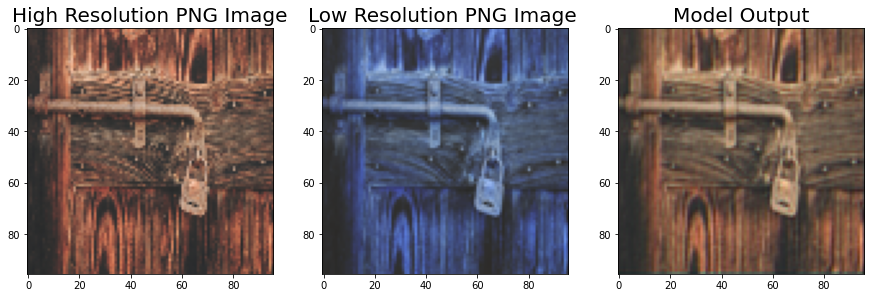

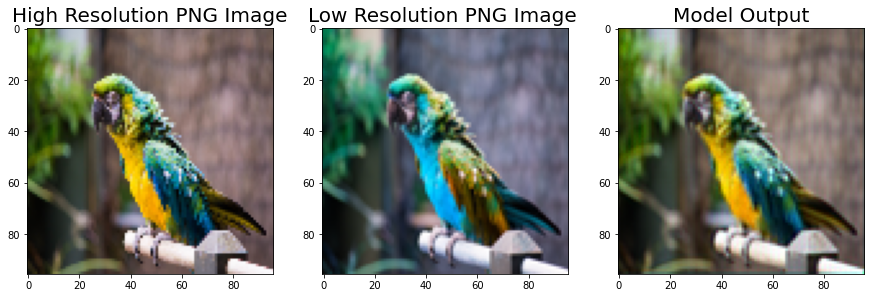

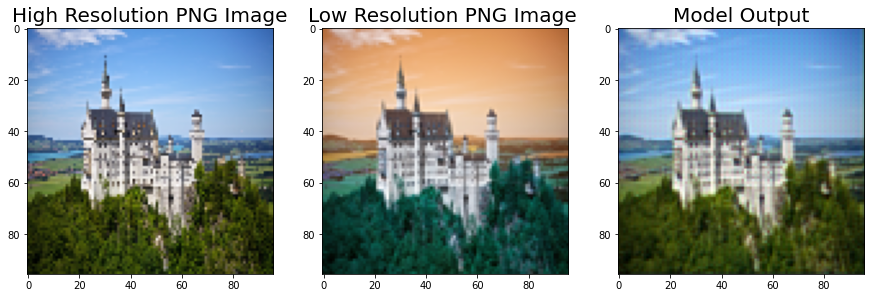

In [18]:
"""
function gets images and displays them side by side for comparison
"""
def show_model_output(hq_image, lq_image, encoder_output):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Resolution PNG Image', color = 'black', fontsize = 20)
    plt.imshow(hq_image)
    plt.subplot(1,3,2)
    plt.title('Low Resolution PNG Image ', color = 'black', fontsize = 20)
    plt.imshow(lq_image)
    plt.subplot(1,3,3)
    plt.title('Model Output', color = 'black', fontsize = 20)
    plt.imshow(encoder_output)
    plt.show()

for photo_triple in range(1, 4):
    encoder_output = np.clip(encoder_with_batch_normalization.predict(test_low_image[photo_triple].reshape(1, SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    show_model_output(test_high_image[photo_triple],test_low_image[photo_triple], encoder_output)

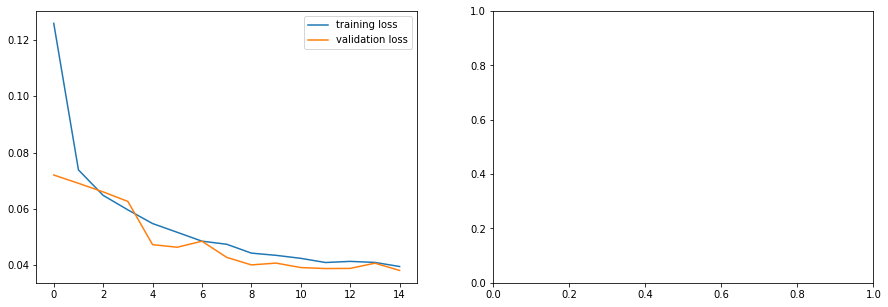

In [19]:
def show_training_loss_in_graph(model_training_history):
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    ax[0].plot(model_training_history.history['loss'], label='training loss')
    ax[0].plot(model_training_history.history['val_loss'], label='validation loss')
    ax[0].legend()
    
show_training_loss_in_graph(history_with_batch_norm)